In [1]:
# import gymnasium as gym
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.multiprocessing as mp
import threading
from torch.cuda import Stream
from torch.autograd.functional import jacobian
from torch.func import functional_call
# from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import matplotlib.animation as animation
from IPython.display import display, HTML
import dosing_rl_gym
# from dosing_rl_gym.util import plot_env
from joblib import Parallel, delayed

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mp.set_start_method('spawn', force=True)

In [2]:
# Hyperparameters
learning_rate = 1e-2
value_lr = 5e-3
gamma = 0.9
hidden_size = 64
batch_size = 1500
C = 350  # Gradient clipping threshold
# sigma = C * 0.0001  # Standard deviation of Gaussian noise
n_obs = 9
normalise_factor = [200, 112, 112, 56, 56, 840, 1640, 200, 1640]
env_name = "Diabetic-v1"
norms = []

def normalise(obs):
        for i in range(9):
            obs[i] = obs[i] / normalise_factor[i]
        return obs

def cross_entropy_loss(probs):
    return -torch.sum(probs * torch.log(probs + 1e-8), dim=-1).mean()

def log_barrier_loss(probs):
    log_probs = torch.log(probs + 1e-8)
    return -torch.sum(log_probs, dim=-1).mean()

# Policy Network
class PolicyNet(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(obs_dim, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, act_dim),
            nn.Softmax(dim=-1)
        )
    
    def forward(self, obs):
        return self.fc(obs)

# Value Network
class ValueNet(nn.Module):
    def __init__(self, obs_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(obs_dim, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, obs):
        return self.fc(obs).squeeze()
    

class Agent:
    def __init__(self, sig=1e-4, C=350, beta=0.0, n_episodes=20, n_actions=5, device='cpu', regularizer=cross_entropy_loss, method=2):
        self.sigma = sig * C / n_episodes
        self.beta = beta
        self.n_episodes = n_episodes
        self.action_multiplier = 10 / (n_actions - 1)
        self.C = C
        self.norms = []
        self.regularizer = regularizer
        self.method = method
        self.epoch_wise_returns = []
        
        self.device = device
        self.policy = PolicyNet(n_obs, n_actions).to(self.device)
        self.value_net = ValueNet(n_obs).to(self.device)
        self.policy_cpu = PolicyNet(n_obs, n_actions).to("cpu")            # For inference (CPU)
        self.policy_cpu.load_state_dict(self.policy.state_dict())

        # self.policy = PolicyNet(n_obs, n_actions)
        # self.value_net = ValueNet(n_obs).to("cpu")

        self.policy_optimizer = optim.Adam(self.policy.parameters(), lr=learning_rate)
        self.value_optimizer = optim.Adam(self.value_net.parameters(), lr=value_lr)
        env_name = "Diabetic-v1"       
        self.env = gym.make(env_name)
        self.env.set_episode_length(10)

        # batch_lens = torch.tensor([self.env.episode_length-2] * n_episodes)  # [n_episodes]
        # position_in_episode = torch.cat([torch.arange(l, 0, -1, device=device) for l in batch_lens])  # [T, ..., 1]
        # self.gamma_powers = gamma ** position_in_episode
        # self.gamma_powers = self.gamma_powers.to(device)
        # self.episode_ids = torch.repeat_interleave(torch.arange(len(batch_lens)), batch_lens).to(self.device)  # [T, ..., 1]
        

    def get_action(self, obs):
        obs = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)  # shape: [1, obs_dim]
        with torch.no_grad():
            probs = self.policy_cpu(obs)
        action = torch.multinomial(probs, num_samples=1).item()
        return action

    def compute_returns(self, rewards, gamma):
        returns = [0] * len(rewards)
        G = 0  # If truncated, use V(s) instead of 0
        for i in reversed(range(len(rewards))):
            G = rewards[i] + gamma * G
            returns[i] = G
        return returns

    # def compute_extras(self, batch_last_states, batch_lens):
    #     """
    #     Inputs:
    #         - batch_last_states: [n_episodes, state_dim], final states of episodes (tensor on GPU)
    #         - batch_lens: [n_episodes], lengths of each episode (tensor on GPU or CPU)
    #         - gamma: float
    #     Output:
    #         - extras: [sum(batch_lens)], extra values for each state in the batch (tensor on GPU)
    #     """   

    #     # Step 1: Compute final state values
    #     v_final = self.value_net(batch_last_states).squeeze()  # shape: [n_episodes]

    #     extras = self.gamma_powers * v_final[self.episode_ids]

    #     return extras
    
    def compute_extras(self, batch_last_states, batch_lens):
        """
        Inputs:
            - batch_last_states: [n_episodes, state_dim], final states of episodes (tensor on GPU)
            - batch_lens: [n_episodes], lengths of each episode (tensor on GPU or CPU)
            - gamma: float
        Output:
            - extras: [sum(batch_lens)], extra values for each state in the batch (tensor on GPU)
        """
        device = batch_last_states.device
        # batch_lens = batch_lens.to(device)

        # Step 1: Compute final state values
        v_final = self.value_net(batch_last_states).squeeze()  # shape: [n_episodes]

        # Step 2: Generate full index range for all episodes
        total_len = batch_lens.sum()
        episode_ids = torch.repeat_interleave(torch.arange(len(batch_lens), device=device), batch_lens)
        
        # Step 3: Position within each episode (reverse)
        gamma_powers = torch.cat([gamma ** torch.arange(l, 0, -1, device=device) for l in batch_lens])  # [T, ..., 1]

        # Step 4: Compute extras using gamma^position * v_final[episode_id]
        # gamma_powers = gamma ** position_in_episode
        extras = gamma_powers * v_final[episode_ids]

        return extras    
    
    
    # Method 1 (privatising gradients before applying FIM)
    def get_privatised_gradients(self, individual_losses, batch_lens):
        # print(batch_lens.device)
        starts = torch.cumsum(torch.cat([torch.tensor([0], device=self.device), batch_lens[:-1]]), dim=0)
        batch_losses = torch.stack([
            individual_losses[start:start + length].sum()
            for start, length in zip(starts, batch_lens)
        ])

        batch_grads = []
        for loss in batch_losses:
            grad_tensors = torch.autograd.grad(loss, self.policy.parameters(), retain_graph=True)
            
            flat_grads = torch.cat([g.view(-1) for g in grad_tensors])  # Flatten all gradients
            norm = torch.norm(flat_grads, p=2)  # Compute L2 norm
            
            # Clip gradient if norm exceeds 1
            clip_coef = 1.0 if norm <= self.C else (self.C/norm)
            clipped_grads = [g * clip_coef for g in grad_tensors]  # Apply scaling

            batch_grads.append(clipped_grads)

        # Compute mean of clipped gradients across all batches
        avg_grads = []
        for grad_tensors in zip(*batch_grads):
            avg_grads.append(torch.mean(torch.stack(grad_tensors), dim=0))
        
        # Add Gaussian noise
        noisy_grads = [g + torch.randn_like(g) * self.sigma for g in avg_grads]
        return torch.cat([g.view(-1) for g in noisy_grads])


    def update_policy_npg(self, batch_obs, batch_acts, batch_advantages, batch_lens):
        self.policy_optimizer.zero_grad()
        probs = self.policy(batch_obs)
        log_probs = torch.log(probs.gather(1, batch_acts.unsqueeze(1)).squeeze())

        # Compute vanilla policy gradients (∇θ log π * advantage)
        individual_losses = -log_probs * batch_advantages
        
        # Add entropy regularization
        # dist = torch.distributions.Categorical(probs=probs)    
        # entropy = dist.entropy()
        entropy = self.regularizer(probs)
        individual_losses_reg = individual_losses - self.beta * entropy   # Regularize with entropy
        
        grad_vector = self.get_privatised_gradients(individual_losses_reg, batch_lens)

        # Fisher-vector product approximation
        def fisher_vector_product(v, damping=1e-3):
            torch.autograd.set_detect_anomaly(True)
            # Make sure v doesn't carry gradients
            v = v.detach() 

            # Recompute KL divergence (create_graph=True to keep track of higher order derivatives)
            probs = self.policy(batch_obs)
            dist = torch.distributions.Categorical(probs=probs)
            with torch.no_grad():
                old_probs = self.policy(batch_obs)
                old_dist = torch.distributions.Categorical(probs=old_probs)

            kl = torch.distributions.kl_divergence(old_dist, dist).mean()

            # First gradient: d(kl)/d(theta)
            kl_grads = torch.autograd.grad(kl, self.policy.parameters(), create_graph=True)
            flat_kl_grads = torch.cat([g.contiguous().view(-1) for g in kl_grads])

            # Compute dot product with v
            kl_v = (flat_kl_grads * v).sum()

            # Second gradient: d²(kl)/d(theta)² * v
            fisher_vec_prod = torch.autograd.grad(kl_v, self.policy.parameters(), retain_graph=True)
            fisher_vec_prod = torch.cat([g.contiguous().view(-1) for g in fisher_vec_prod])

            return fisher_vec_prod + damping * v


        # Use conjugate gradient to solve Fv = g
        def conjugate_gradient(fvp_fn, b, n_steps=10, residual_tol=1e-10):
            torch.autograd.set_detect_anomaly(True)
            x = torch.zeros_like(b)
            r = b.clone()
            p = b.clone()
            rsold = torch.dot(r, r)

            for _ in range(n_steps):
                Ap = fvp_fn(p)
                alpha = rsold / (torch.dot(p, Ap) + 1e-10)
                x = x + alpha * p
                r = r - alpha * Ap
                rsnew = torch.dot(r, r)
                if rsnew < residual_tol:
                    break
                p = r + (rsnew / rsold) * p
                rsold = rsnew
            return x

        natural_grad = conjugate_gradient(fisher_vector_product, grad_vector)
        
        # Apply the natural gradient step
        step_size = learning_rate
        index = 0
        for param in self.policy.parameters():
            param_length = param.numel()
            direction = natural_grad[index:index + param_length].view(param.size())
            if param.grad is not None:
                param.grad = direction
            else:
                param.grad = torch.zeros_like(param).copy_(direction)
            index += param_length

        self.policy_optimizer.step()
        
        return individual_losses_reg.mean().item(), natural_grad
    

    # Method 2 (using sequential computation)
    def get_npg_grad2(self, batch_obs, loss):

        gradient = torch.autograd.grad(loss, self.policy.parameters(), retain_graph=True)
        flat_grads = torch.cat([g.view(-1) for g in gradient])  # Flatten all gradients

        # Fisher-vector product approximation
        def fisher_vector_product(v, damping=1e-3):
            torch.autograd.set_detect_anomaly(True)
            # Make sure v doesn't carry gradients
            v = v.detach() 

            # Recompute KL divergence (create_graph=True to keep track of higher order derivatives)
            probs = self.policy(batch_obs)
            dist = torch.distributions.Categorical(probs=probs)
            with torch.no_grad():
                old_probs = self.policy(batch_obs)
                old_dist = torch.distributions.Categorical(probs=old_probs)

            kl = torch.distributions.kl_divergence(old_dist, dist).mean()

            # First gradient: d(kl)/d(theta)
            kl_grads = torch.autograd.grad(kl, self.policy.parameters(), create_graph=True)
            flat_kl_grads = torch.cat([g.contiguous().view(-1) for g in kl_grads])

            # Compute dot product with v
            kl_v = (flat_kl_grads * v).sum()

            # Second gradient: d²(kl)/d(theta)² * v
            fisher_vec_prod = torch.autograd.grad(kl_v, self.policy.parameters(), retain_graph=True)
            fisher_vec_prod = torch.cat([g.contiguous().view(-1) for g in fisher_vec_prod])

            return fisher_vec_prod + damping * v

        # Use conjugate gradient to solve Fv = g
        def conjugate_gradient(fvp_fn, b, n_steps=10, residual_tol=1e-10):
            torch.autograd.set_detect_anomaly(True)
            x = torch.zeros_like(b)
            r = b.clone()
            p = b.clone()
            rsold = torch.dot(r, r)

            for _ in range(n_steps):
                Ap = fvp_fn(p)
                alpha = rsold / (torch.dot(p, Ap) + 1e-10)
                x = x + alpha * p
                r = r - alpha * Ap
                rsnew = torch.dot(r, r)
                if rsnew < residual_tol:
                    break
                p = r + (rsnew / rsold) * p
                rsold = rsnew
            return x
        
        return conjugate_gradient(fisher_vector_product, flat_grads)
    

    def update_policy_npg2(self, batch_obs, batch_acts, batch_advantages, batch_lens):
        
        self.policy_optimizer.zero_grad()
        probs = self.policy(batch_obs)
        log_probs = torch.log(probs.gather(1, batch_acts.unsqueeze(1)).squeeze())

        # Compute vanilla policy gradients (∇θ log π * advantage)
        individual_losses = -log_probs * batch_advantages
        
        # Add entropy regularization
        dist = torch.distributions.Categorical(probs=probs)    
        entropy = dist.entropy()
        individual_losses_reg = individual_losses - self.beta * entropy   # Regularize with entropy
        
        starts = torch.cumsum(torch.cat([torch.tensor([0], device=self.device), batch_lens[:-1]]), dim=0)
        batch_losses = torch.stack([
            individual_losses_reg[start:start + length].sum()
            for start, length in zip(starts, batch_lens)
        ])

        batch_grads = [self.get_npg_grad2(batch_obs, loss) for loss in batch_losses]

        norms = [torch.norm(grad) for grad in batch_grads]
        clip_coeffs = [(1.0 if norm <= self.C else (self.C/norm)) for norm in norms]
        clipped_grads = [g * clip_coef for g, clip_coef in zip(batch_grads, clip_coeffs)]
        self.norms.extend(norms)            
            
        avg_grad_vector = torch.mean(torch.stack(clipped_grads), dim=0)
        final_grad = avg_grad_vector + torch.randn_like(avg_grad_vector) * self.sigma              
        
        
        # # Apply the natural gradient step
        # step_size = learning_rate
        # index = 0
        # for param in self.policy.parameters():
        #     param_length = param.numel()
        #     direction = final_grad[index:index + param_length].view(param.size())
        #     if param.grad is not None:
        #         param.grad = direction
        #     else:
        #         param.grad = torch.zeros_like(param).copy_(direction)
        #     index += param_length

        # self.policy_optimizer.step()
        
        return batch_losses.mean().item(), final_grad

    
    # Method2 (using batched computation)
    def batched_fisher_vector_product5(self, V, batch_obs, flat_kl_grads, damping=1e-3):
        """Compute Fisher-vector product for multiple vectors."""
        V = V.detach()  # Shape: [param_size, num_episodes]

        # Compute dot product for each column of V
        dot_product = flat_kl_grads @ V  # [num_episodes]

        # Compute Hessian-vector product for each column
        F_V_list = []
        for i in range(V.shape[1]):
            dp_i = dot_product[i]
            fvp_i = torch.autograd.grad(dp_i, self.policy.parameters(), retain_graph=True)
            flat_fvp_i = torch.cat([g.contiguous().view(-1) for g in fvp_i])
            F_V_list.append(flat_fvp_i)
        F_V = torch.stack(F_V_list, dim=1)  # [param_size, num_episodes]
        

        return F_V + damping * V

    def batched_conjugate_gradient5(self, G, batch_obs, n_steps=10, residual_tol=1e-10):
        """Solve F x_i = g_i for all episodes using batched CG."""
        num_episodes = G.shape[1]
        X = torch.zeros_like(G)  # [param_size, num_episodes]
        R = G.clone()            # Residual
        P = G.clone()            # Search direction
        rsold = torch.sum(R * R, dim=0)  # [num_episodes]

        with torch.no_grad():
            old_probs = self.policy(batch_obs)
            old_dist = torch.distributions.Categorical(probs=old_probs)
        
        probs = self.policy(batch_obs)
        dist = torch.distributions.Categorical(probs=probs)
        kl = torch.distributions.kl_divergence(old_dist, dist).mean()

        # First-order gradient of KL divergence
        kl_grads = torch.autograd.grad(kl, self.policy.parameters(), create_graph=True)
        flat_kl_grads = torch.cat([g.contiguous().view(-1) for g in kl_grads])  # [param_size]

        for _ in range(n_steps):
            AP = self.batched_fisher_vector_product5(P, batch_obs, flat_kl_grads)
            alpha = rsold / (torch.sum(P * AP, dim=0) + 1e-10)  # [num_episodes]
            X = X + alpha.unsqueeze(0) * P
            R = R - alpha.unsqueeze(0) * AP
            rsnew = torch.sum(R * R, dim=0)
            if torch.all(rsnew < residual_tol):
                break
            beta = rsnew / (rsold + 1e-10)
            P = R + beta.unsqueeze(0) * P
            rsold = rsnew
        return X

    def get_npg_grad5(self, batch_obs, batch_acts, batch_advantages, batch_lens):
        """Compute natural policy gradients sequentially for basic gradients."""
        # Compute basic gradients sequentially
        probs = self.policy(batch_obs)
        log_probs = torch.log(probs.gather(1, batch_acts.unsqueeze(1)).squeeze())
        individual_losses = -log_probs * batch_advantages
        # dist = torch.distributions.Categorical(probs=probs)
        # entropy = dist.entropy()
        entropy = self.regularizer(probs)
        individual_losses_reg = individual_losses - self.beta * entropy

        starts = torch.cumsum(torch.cat([torch.tensor([0], device=self.device), batch_lens[:-1]]), dim=0)
        batch_losses = torch.stack([
            individual_losses_reg[start:start + length].sum()
            for start, length in zip(starts, batch_lens)
        ])

        G_list = []
        for loss in batch_losses:
            self.policy_optimizer.zero_grad()
            loss.backward(retain_graph=True)
            flat_grads = torch.cat([p.grad.view(-1) for p in self.policy.parameters()])
            G_list.append(flat_grads.detach().clone())
        G = torch.stack(G_list, dim=1)  # [param_size, num_episodes]

        # Compute natural gradients using batched CG
        X = self.batched_conjugate_gradient5(G, batch_obs)
        return X

    def update_policy_npg5(self, batch_obs, batch_acts, batch_advantages, batch_lens):
        """Update policy using vectorized natural gradients."""

        self.policy_optimizer.zero_grad()
        natural_grads = self.get_npg_grad5(batch_obs, batch_acts, batch_advantages, batch_lens)

        # Process gradients: clipping, averaging, and adding noise
        batch_grads = [natural_grads[:, i] for i in range(natural_grads.shape[1])]
        norms = [torch.norm(grad) for grad in batch_grads]
        self.norms.extend(norms)
        clip_coeffs = [1.0 if norm <= self.C else (self.C / norm) for norm in norms]
        clipped_grads = [g * c for g, c in zip(batch_grads, clip_coeffs)]
        avg_grad = torch.mean(torch.stack(clipped_grads), dim=0)
        final_grad = avg_grad + torch.randn_like(avg_grad) * self.sigma

        # Apply gradients to policy parameters
        index = 0
        for param in self.policy.parameters():
            param_length = param.numel()
            param.grad = final_grad[index:index + param_length].view(param.size())
            index += param_length

        self.policy_optimizer.step()
        return 0, final_grad  



    def train_one_epoch(self):        
        
        # start_time = time.time()
        
        batch_obs = []
        batch_acts = []
        batch_q_vals = []
        batch_lens = []
        batch_last_states = []
        batch_rets = []
        undiscounted_rets = []        
        
        # print(obs)
        for _ in range(self.n_episodes):
            obs, _ = self.env.reset()
            done = False
            episode_rewards = []
            episode_obs = []
            episode_acts = []
            ret = 0

            while not done:
                obs = normalise(obs)
                action = self.get_action(obs)
                next_obs, reward, terminated, _ = self.env.step([action*self.action_multiplier])
                done = terminated
                
                episode_rewards.append(reward)
                episode_obs.append(obs)
                episode_acts.append(action)
                
                obs = next_obs
                ret += reward            
            
            batch_last_states.append(obs)         
                
            batch_obs.extend(episode_obs)
            batch_acts.extend(episode_acts)
            batch_rets.extend(self.compute_returns(episode_rewards, gamma))
            batch_lens.append(len(episode_rewards))
            undiscounted_rets.append(ret)
            
        
        batch_obs = torch.tensor(np.array(batch_obs), dtype=torch.float32, device=self.device)
        batch_acts = torch.tensor(batch_acts, dtype=torch.int64, device=self.device)
        batch_rets = torch.tensor(batch_rets, dtype=torch.float32, device=self.device)
        batch_last_states = torch.tensor(np.array(batch_last_states), dtype=torch.float32, device=self.device)
        batch_lens_gpu = torch.tensor(batch_lens, dtype=torch.int64, device=self.device)

        # batch_q_vals = batch_rets
        # time2 = time.time()
        # print("Time for data collection ", time2 - start_time)
        
        # Value Function Loss (Mean Squared Error with previous gradients contribution)
        for i in range(10):        
            batch_v_vals = self.value_net(batch_obs)
            
            batch_extras = self.compute_extras(batch_last_states, batch_lens_gpu)
            # batch_extras2 = self.compute_extras2(batch_last_states, batch_lens_gpu)
            # if not torch.allclose(batch_extras, batch_extras2):
            #     print("Extras mismatch: ", batch_extras, batch_extras2)
            batch_q_vals = batch_rets + batch_extras
            # batch_q_vals = batch_rets

            value_loss = nn.MSELoss()(batch_v_vals, batch_q_vals)        
            self.value_optimizer.zero_grad()
            value_loss.backward()
            self.value_optimizer.step()  
        
        # # Compute Advantage function A(s, a) = Q(s,a) - V_phi(s)
        batch_v_vals = self.value_net(batch_obs)
        batch_advantages = batch_q_vals.detach() - batch_v_vals.detach()
        # batch_advantages = batch_rets

        # time3 = time.time()
        # print("Time for value update ", time3 - time2)

        # batch_obs = batch_obs.to(self.device)
        # batch_acts = batch_acts.to(self.device)
        # batch_advantages = batch_advantages.to(self.device)

        # p2, g2 = self.update_policy_npg4(batch_obs, batch_acts, batch_advantages, batch_lens_gpu)

        # time4 = time.time()
        # print("Time for compute1 ", time4 - time3)

        if self.method == 1:
            policy_loss, g = self.update_policy_npg(batch_obs, batch_acts, batch_advantages, batch_lens_gpu)
        else:
            policy_loss, g = self.update_policy_npg5(batch_obs, batch_acts, batch_advantages, batch_lens_gpu)
        
        # print("Time for computation ", time.time() - time4)

        self.policy_cpu.load_state_dict(self.policy.state_dict())
        
        
        # if not torch.allclose(g, g2):
        #     print("Gradients dont match: ", g, g2)
        #     diff = g - g2
        #     rel_error = torch.norm(diff) / torch.norm(g)
        #     print(f"Relative error: {rel_error.item()}")
        
        return policy_loss, value_loss.item(), np.mean(undiscounted_rets), batch_lens
    
    def train(self, n_epochs=150, verbose=True):       

        for epoch in range(n_epochs):
            policy_loss, value_loss, avg_ret, batch_lens = self.train_one_epoch()
            if verbose:
                print(f"Epoch {epoch+1}: Policy Loss={policy_loss:.3f}, Value Loss={value_loss:.3f}, Avg Return={avg_ret:.3f}, Episodes={len(batch_lens)}")
        
    

In [4]:
agent = Agent(beta=0.1, sig=0, n_actions=5, n_episodes=20, device='cpu', C=1800)
agent.train(n_epochs=200, verbose=True)

Epoch 1: Policy Loss=0.000, Value Loss=17.795, Avg Return=-109.125, Episodes=20
Epoch 2: Policy Loss=0.000, Value Loss=6.858, Avg Return=-111.508, Episodes=20
Epoch 3: Policy Loss=0.000, Value Loss=12.352, Avg Return=-98.524, Episodes=20
Epoch 4: Policy Loss=0.000, Value Loss=13.485, Avg Return=-89.580, Episodes=20
Epoch 5: Policy Loss=0.000, Value Loss=16.011, Avg Return=-61.400, Episodes=20
Epoch 6: Policy Loss=0.000, Value Loss=18.571, Avg Return=-54.953, Episodes=20
Epoch 7: Policy Loss=0.000, Value Loss=16.461, Avg Return=-58.002, Episodes=20
Epoch 8: Policy Loss=0.000, Value Loss=14.551, Avg Return=-57.522, Episodes=20
Epoch 9: Policy Loss=0.000, Value Loss=18.244, Avg Return=-71.364, Episodes=20
Epoch 10: Policy Loss=0.000, Value Loss=18.425, Avg Return=-51.533, Episodes=20
Epoch 11: Policy Loss=0.000, Value Loss=16.647, Avg Return=-62.787, Episodes=20
Epoch 12: Policy Loss=0.000, Value Loss=16.821, Avg Return=-62.317, Episodes=20
Epoch 13: Policy Loss=0.000, Value Loss=15.781, 

In [ ]:
agent1 = Agent(beta=0.0, sig=0, n_actions=5, n_episodes=20, device='cpu', C=350, method=1)
agent1.train(n_epochs=200, verbose=True)

In [ ]:
agent1_reg = Agent(beta=0.1, sig=0, n_actions=5, n_episodes=20, device='cpu', C=350, method=1)
agent1_reg.train(n_epochs=200, verbose=True)

In [ ]:
agent2 = Agent(beta=0.0, sig=0, n_actions=5, n_episodes=20, device='cpu', C=1800, method=2)
agent2.train(n_epochs=200, verbose=True)

In [ ]:
agent2_reg = Agent(beta=0.0, sig=0, n_actions=5, n_episodes=20, device='cpu', C=1800, method=2)
agent2_reg.train(n_epochs=200, verbose=True)

In [4]:
def get_ideal_agents(i):
    import dosing_rl_gym
    if i==0:
        agent1 = Agent(beta=0.0, sig=0, n_actions=5, n_episodes=20, device='cpu', C=350, method=1)
        agent1.train(n_epochs=200, verbose=False)
        return agent1
    elif i==1:
        agent1_reg = Agent(beta=0.1, sig=0, n_actions=5, n_episodes=20, device='cpu', C=350, method=1)
        agent1_reg.train(n_epochs=200, verbose=False)
        return agent1_reg
    elif i==2:
        agent2 = Agent(beta=0.0, sig=0, n_actions=5, n_episodes=20, device='cpu', C=1400, method=2)
        agent2.train(n_epochs=200, verbose=False)
        return agent2
    elif i==3:
        agent2_reg = Agent(beta=0.1, sig=0, n_actions=5, n_episodes=20, device='cpu', C=1400, method=2)
        agent2_reg.train(n_epochs=200, verbose=False)
        return agent2_reg

ideal_agents = Parallel(n_jobs=-1)(delayed(get_ideal_agents)(i) for i in range(4))
agent1 = ideal_agents[0]
agent1_reg = ideal_agents[1]
agent2 = ideal_agents[2]
agent2_reg = ideal_agents[3]

In [17]:
norms = agent2.norms
norms.sort()
idx90 = int(len(norms) * 0.90)
idx95 = int(len(norms) * 0.95)
print("avg norm: ", sum(norms)/len(norms))
print("50th percentile of nomrs:", norms[int(len(norms) * 0.5)])
print("80th percentile of nomrs:", norms[int(len(norms) * 0.8)])
print("90th percentile of norms:", norms[idx90])
print("95th percentile of norms:", norms[idx95])
print("Max norm: ", norms[int(len(norms)-1)])


avg norm:  tensor(654.1793)
50th percentile of nomrs: tensor(446.4478)
80th percentile of nomrs: tensor(912.3101)
90th percentile of norms: tensor(1473.9663)
95th percentile of norms: tensor(2155.6519)
Max norm:  tensor(6317.7236)


c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\gym\utils\passive_env_checker.py:141: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\gym\utils\passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\gym\utils\passive_env_checker.py:219: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\gym\utils\passive_env_checker.py:141: UserWarning: WARN: The obs returned by the `step()` method 

Shape of env.t: (145,)
[np.float64(6.0), np.float64(6.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(7.5), np.float64(2.5), np.float64(0.0), np.float64(0.0), np.float64(5.0), np.float64(0.0), np.float64(5.0), np.float64(2.5), np.float64(2.5), np.float64(0.0), np.float64(2.5), np.float64(2.5), np.float64(2.5), np.float64(5.0), np.float64(0.0), np.float64(0.0), np.float64(7.5), np.float64(0.0), np.float64(0.0), np.float64(5.0), np.float64(2.5), np.float64(2.5), np.float64(0.0), np.float64(5.0), np.float64(2.5), np.float64(10.0), np.float64(7.5), np.float64(0.0), np.float64(0.0), np.float64(2.5), np.float64(2.5), np.float64(0.0), np.float64(0.0), np.float64(2.5), np.float64(2.5), np.float64(2.5), np.float64(5.0), np.float64(0.0), np.float64(0.0), np.float64(5.0), np.float64(0.0), np.float64(2.5), np.float64(5.0), np.float64(2.5), np.float64(0.0), np.float64(2.5), np.float64(5.0), np.float64(0.0), np.float64(2.5), np.float64(5.0), np.float64(0.0), np.flo

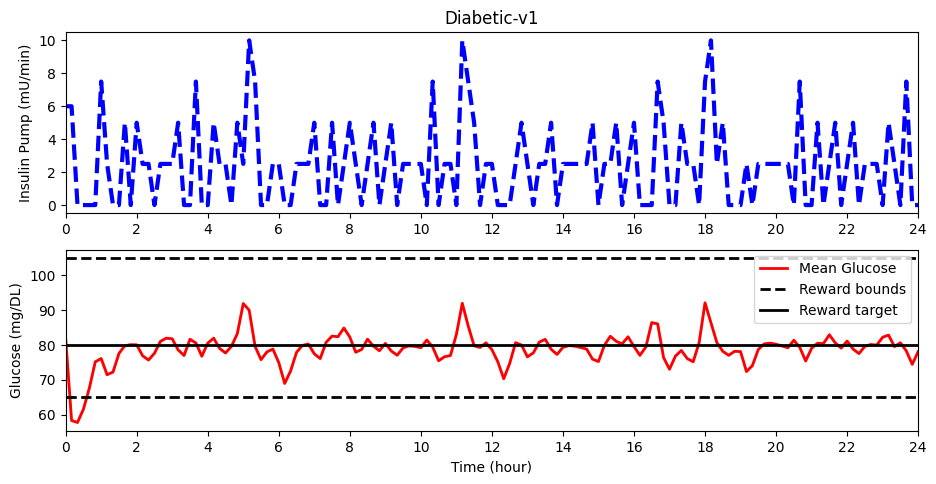

In [5]:
def plot_env(agent, n_episodes):
    env = gym.make(env_name)
    env.set_episode_length(10)
    glucose_list = []
    action_list = []
    rewards_list = []
    for e in range(n_episodes):
        state, _ = env.reset()
        for _ in range(env.episode_length-2):
            state = normalise(state)
            action = agent.get_action(state)
            # get_max(state)
            state, reward, done, _ = env.step(np.array([action*agent.action_multiplier]))
            rewards_list.append(reward)
            # if done:
            #     break
        glucose_list.append(env.G)
        action_list.append(env.u)
        

    print(f"Shape of env.t: {np.shape(env.t)}")
    # print(f"Shape of env.u: {np.shape(env.u)}")
    print(env.u)
    print(rewards_list)
    # Plot the results
    plt.figure(1, figsize=(11,8))
    ticks = np.linspace(0,24,13)

    ax = plt.subplot(3,1,1)
    plt.plot(env.t, env.u, 'b--', linewidth=3)
    plt.ylabel('Insulin Pump (mU/min)')
    plt.xlim([0,24])
    plt.xticks(ticks)
    plt.title(env_name)

    ax = plt.subplot(3,1,2)
    for l in glucose_list:
        plt.plot(env.t, l, 'r-',linewidth=2, alpha=0.2)
    plt.plot(env.t, np.array(glucose_list).mean(axis=0),'r-',linewidth=2, label='Mean Glucose')
    plt.plot([0,24],[105,105],'k--',linewidth=2,label='Reward bounds')
    plt.plot([0,24],[80,80],'k-',linewidth=2,label='Reward target')
    plt.plot([0,24],[65,65],'k--',linewidth=2)
    plt.ylabel('Glucose (mg/DL)')
    plt.legend(loc='best')
    plt.xlim([0,24])
    plt.xticks(ticks)
    plt.xlabel('Time (hour)')
    plt.show()

env_name = "Diabetic-v1"
plot_env(agent, 1)

In [6]:
def get_avg_reward(agent, n_episodes):
    # env = gym.make(env_name)
    # env.set_episode_length(10)
    
    ret_list = []
    for e in range(n_episodes):
        state, _ = agent.env.reset()
        ret = 0
        # print(agent.value_net(torch.tensor(state, dtype=torch.float32)))
        for _ in range(agent.env.episode_length-2):
            state = normalise(state)
            action = agent.get_action(state)
            state, reward, done, _ = agent.env.step(np.array([action*agent.action_multiplier]))
            ret += reward
            # if done:
            #     break
        ret_list.append(ret)
    avg_ret = np.mean(ret_list)
    std_ret = np.std(ret_list)
    return avg_ret, std_ret

avg_ret, std_ret = get_avg_reward(agent, 100)
print(f"Average reward over 100 episodes: {avg_ret:.2f} ± {std_ret:.2f}")

Average reward over 100 episodes: 124.88 ± 3.27


In [20]:
for ag in ideal_agents:
    avg_ret, std_ret = get_avg_reward(ag, 100)
    print(f"Average reward over 100 episodes: {avg_ret:.2f} ± {std_ret:.2f}")

Average reward over 100 episodes: 108.68 ± 7.23
Average reward over 100 episodes: 121.10 ± 4.39
Average reward over 100 episodes: 124.69 ± 3.16
Average reward over 100 episodes: 128.20 ± 3.27


In [8]:
def evaluate_sigma(sigma, beta, method, C):
    import dosing_rl_gym
    
    agent1 = Agent(sig=sigma, beta=beta, n_episodes=20, n_actions=5, method=method, C=C)
    agent1.train(n_epochs=200, verbose=False)
    avg_ret, std_ret = get_avg_reward(agent1, 100)
    return sigma, avg_ret, std_ret

In [ ]:
sigma_vals = [1e-4, 1e-3, 0.01, 0.1, 1, 10]

results1 = Parallel(n_jobs=-1)(delayed(evaluate_sigma)(x, 0, 1, 350) for x in sigma_vals)
results1_reg = Parallel(n_jobs=-1)(delayed(evaluate_sigma)(x, 0.1, 1, 350) for x in sigma_vals)
results2 = Parallel(n_jobs=-1)(delayed(evaluate_sigma)(x, 0, 2, 1400) for x in sigma_vals)
results2_reg = Parallel(n_jobs=-1)(delayed(evaluate_sigma)(x, 0.1, 2, 1400) for x in sigma_vals)

# for sigma, avg_ret, std_ret in results:
#     print(f"Average reward for sigma={sigma}: {avg_ret:.2f} ± {std_ret:.2f}")

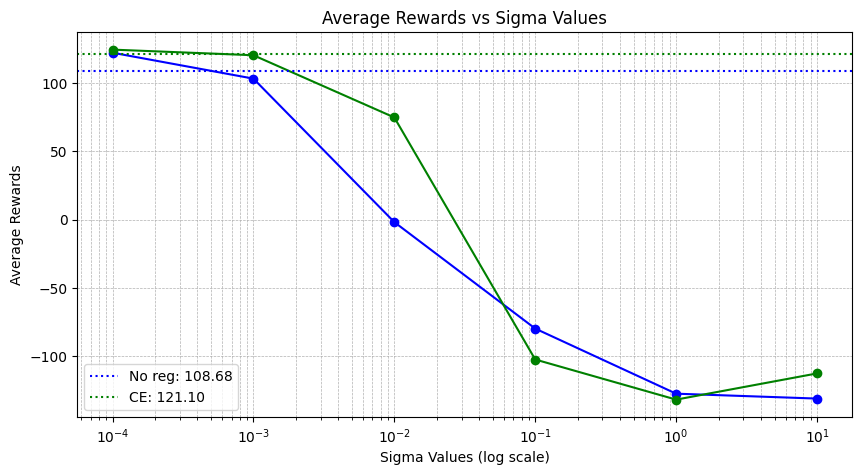

In [33]:
avg_rets1 = [res[1] for res in results1]
avg_rets1_reg = [res[1] for res in results1_reg]
avg_rets2 = [res[1] for res in results2]
avg_rets2_reg = [res[1] for res in results2_reg]
avg_rets2_reg[4] = 96.07042966012635

ideal_ret1 = 108.68
ideal_ret1_reg = 121.10
ideal_ret2 = 124.69
ideal_ret2_reg = 128.20

plt.figure(figsize=(10, 5))
plt.semilogx(sigma_vals, avg_rets1, marker='o', linestyle='-', color='b')
plt.semilogx(sigma_vals, avg_rets1_reg, marker='o', linestyle='-', color='g')
plt.axhline(y=ideal_ret1, color='b', linestyle=':', linewidth=1.5, label=f'No reg: {ideal_ret1:.2f}')
plt.axhline(y=ideal_ret1_reg, color='g', linestyle=':', linewidth=1.5, label=f'CE: {ideal_ret1_reg:.2f}')

plt.xlabel("Sigma Values (log scale)")
plt.ylabel("Average Rewards")
plt.title("Average Rewards vs Sigma Values")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.show()

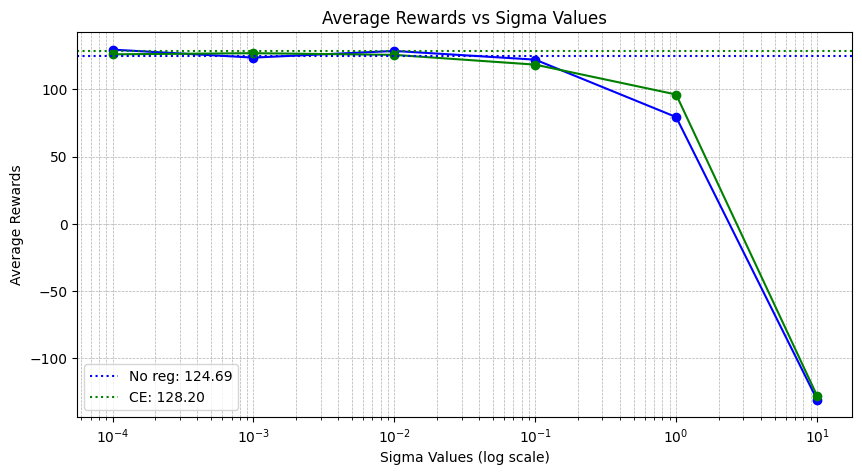

In [34]:
plt.figure(figsize=(10, 5))
plt.semilogx(sigma_vals, avg_rets2, marker='o', linestyle='-', color='b')
plt.semilogx(sigma_vals, avg_rets2_reg, marker='o', linestyle='-', color='g')
plt.axhline(y=ideal_ret2, color='b', linestyle=':', linewidth=1.5, label=f'No reg: {ideal_ret2:.2f}')
plt.axhline(y=ideal_ret2_reg, color='g', linestyle=':', linewidth=1.5, label=f'CE: {ideal_ret2_reg:.2f}')

plt.xlabel("Sigma Values (log scale)")
plt.ylabel("Average Rewards")
plt.title("Average Rewards vs Sigma Values")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.show()

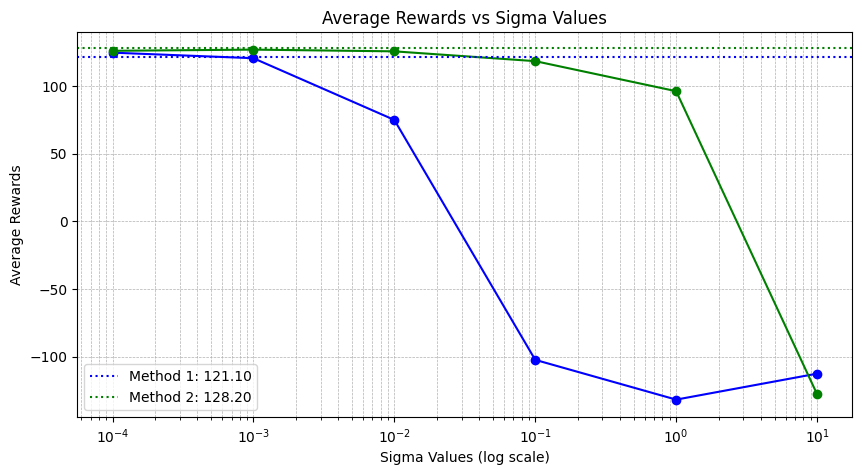

In [35]:
plt.figure(figsize=(10, 5))
plt.semilogx(sigma_vals, avg_rets1_reg, marker='o', linestyle='-', color='b')
plt.semilogx(sigma_vals, avg_rets2_reg, marker='o', linestyle='-', color='g')
plt.axhline(y=ideal_ret1_reg, color='b', linestyle=':', linewidth=1.5, label=f'Method 1: {ideal_ret1_reg:.2f}')
plt.axhline(y=ideal_ret2_reg, color='g', linestyle=':', linewidth=1.5, label=f'Method 2: {ideal_ret2_reg:.2f}')

plt.xlabel("Sigma Values (log scale)")
plt.ylabel("Average Rewards")
plt.title("Average Rewards vs Sigma Values")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.show()

In [28]:
def evaluate_eps_delta_reg(epsilon, delta, beta, method, C):
    import dosing_rl_gym
    if epsilon < 1:
        z = np.sqrt(2 * np.log(1.25 / delta)) / epsilon
    else:
        c2 = np.sqrt(np.log(2/(np.sqrt(16*delta+1)-1)))
        z =(c2 + np.sqrt(c2*c2 + epsilon)) / (epsilon * np.sqrt(2))
    
    z = float(z)
    
    agent1 = Agent(beta=beta, method=method, sig=z, n_episodes=20, C=C)
    agent1.train(n_epochs=200, verbose=False)
    avg_ret, std_ret = get_avg_reward(agent1, 100)
    return z, avg_ret, std_ret

In [29]:
epsilon_vals = [0.1, 0.2, 0.5, 1.0, 2, 5.0, 10.0, 20.0, 50, 100]
# z_vals = [evaluate_eps_delta(epsilon, delta) for epsilon in epsilon_vals]
results1_eps_del5_reg = Parallel(n_jobs=-1)(delayed(evaluate_eps_delta_reg)(epsilon, 1e-5, 0.1, 1, 350) for epsilon in epsilon_vals)
# results1_eps_del1_reg = Parallel(n_jobs=-1)(delayed(evaluate_eps_delta_reg)(epsilon, 1e-1, 0.1, 1, 350) for epsilon in epsilon_vals)
results2_eps_del5_reg = Parallel(n_jobs=-1)(delayed(evaluate_eps_delta_reg)(epsilon, 1e-5, 0.1, 2, 1400) for epsilon in epsilon_vals)
# results2_eps_del1_reg = Parallel(n_jobs=-1)(delayed(evaluate_eps_delta_reg)(epsilon, 1e-1, 0.1, 2, 1800) for epsilon in epsilon_vals)

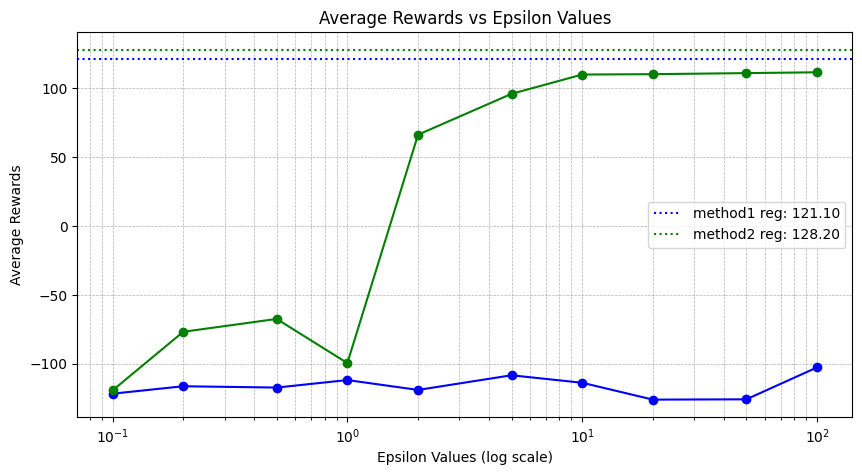

In [31]:
avg_rets1_eps_del5_reg = [res[1] for res in results1_eps_del5_reg]
avg_rets2_eps_del5_reg = [res[1] for res in results2_eps_del5_reg]

plt.figure(figsize=(10, 5))
plt.semilogx(epsilon_vals, avg_rets1_eps_del5_reg, marker='o', linestyle='-', color='b')
plt.semilogx(epsilon_vals, avg_rets2_eps_del5_reg, marker='o', linestyle='-', color='g')
plt.axhline(y=ideal_ret1_reg, color='b', linestyle=':', linewidth=1.5, label=f'method1 reg: {ideal_ret1_reg:.2f}')
plt.axhline(y=ideal_ret2_reg, color='g', linestyle=':', linewidth=1.5, label=f'method2 reg: {ideal_ret2_reg:.2f}')
plt.xlabel("Epsilon Values (log scale)")
plt.ylabel("Average Rewards")
plt.title("Average Rewards vs Epsilon Values")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.show()

In [32]:
avg_rets2_eps_del5_reg[5]

np.float64(96.07042966012635)

In [ ]:
# avg_rets1_eps_del1_reg = [res[1] for res in results1_eps_del1_reg]
# avg_rets2_eps_del1_reg = [res[1] for res in results2_eps_del1_reg]

# plt.figure(figsize=(8, 5))
# plt.semilogx(epsilon_vals, avg_rets1_eps_del1_reg, marker='o', linestyle='-', color='b')
# plt.semilogx(epsilon_vals, avg_rets2_eps_del1_reg, marker='o', linestyle='-', color='g')
# plt.axhline(y=ideal_ret1_reg, color='b', linestyle=':', linewidth=1.5, label=f'method1 reg: {ideal_ret1_reg:.2f}')
# plt.axhline(y=ideal_ret2_reg, color='g', linestyle=':', linewidth=1.5, label=f'method2 reg: {ideal_ret2_reg:.2f}')
# plt.xlabel("Epsilon Values (log scale)")
# plt.ylabel("Average Rewards")
# plt.title("Average Rewards vs Epsilon Values")
# plt.grid(True, which="both", linestyle="--", linewidth=0.5)
# plt.legend()
# plt.show()

In [38]:
def evaluate_heads(heads):
    import dosing_rl_gym
    
    agent1 = Agent(sig=1e-6, beta=0.1, n_episodes=20, n_actions=heads, device='cpu')
    agent1.train(n_epochs=200, verbose=False)
    avg_ret, std_ret = get_avg_reward(agent1, 100)
    return heads, avg_ret, std_ret

In [39]:
n_heads = [2, 3, 4, 5, 6, 7]
# mp.set_start_method('spawn', force=True)
results = Parallel(n_jobs=-1)(delayed(evaluate_heads)(x) for x in n_heads)
for heads, avg_ret, std_ret in results:
    print(f"Average reward for heads={heads}: {avg_ret:.2f} ± {std_ret:.2f}")

Average reward for heads=2: 110.12 ± 5.07
Average reward for heads=3: 117.00 ± 4.67
Average reward for heads=4: 126.07 ± 4.33
Average reward for heads=5: 122.04 ± 3.17
Average reward for heads=6: 122.15 ± 3.45
Average reward for heads=7: 123.85 ± 3.53


In [37]:
sigma_vals = [1e-4, 1e-3, 0.01, 0.1, 1, 10]
# mp.set_start_method('spawn', force=True)
results = Parallel(n_jobs=-1)(delayed(evaluate_sigma_regularized)(x) for x in sigma_vals)

for sigma, avg_ret, std_ret in results:
    print(f"Average reward for sigma={sigma}: {avg_ret:.2f} ± {std_ret:.2f}")


Average reward for sigma=0.0001: 103.76 ± 6.15
Average reward for sigma=0.001: 108.14 ± 4.39
Average reward for sigma=0.01: -42.50 ± 57.11
Average reward for sigma=0.1: -73.09 ± 30.64
Average reward for sigma=1: -120.75 ± 18.53
Average reward for sigma=10: -113.80 ± 20.64


In [18]:
def evaluate_beta(beta):
    import dosing_rl_gym
    agent1 = Agent(beta=beta, sig=0, n_episodes=20, n_actions=5, device='cpu', C=1400, method=2)
    agent1.train(n_epochs=200, verbose=False)
    avg_ret, std_ret = get_avg_reward(agent1, 100)
    return beta, avg_ret, std_ret

In [19]:
beta_vals = [0, 1e-3, 1e-2, 0.1, 1, 10]
results_beta = Parallel(n_jobs=-1)(delayed(evaluate_beta)(x) for x in beta_vals)
for beta, avg_ret, std_ret in results_beta:
    print(f"Average reward for beta={beta}: {avg_ret:.2f} ± {std_ret:.2f}")

Average reward for beta=0: 117.73 ± 3.76
Average reward for beta=0.001: 113.97 ± 4.17
Average reward for beta=0.01: 127.52 ± 2.97
Average reward for beta=0.1: 126.87 ± 2.87
Average reward for beta=1: 59.21 ± 18.71
Average reward for beta=10: -111.49 ± 25.59
